In [1]:
import torch.nn as nn

from torch.nn.functional import cosine_similarity

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 16

In [3]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset_x = ImageFolder(root='data/photo', transform=transform)
dataset_y = ImageFolder(root='data/monet', transform=transform)

train_loader_x = DataLoader(dataset_x, batch_size=batch_size, shuffle=True)
train_loader_y = DataLoader(dataset_y, batch_size=batch_size, shuffle=True)

# Architecture and losses

In [4]:
# Define the LSGAN loss as in https://arxiv.org/pdf/1611.04076
def lsgan_loss(pred, target):
    return torch.mean((pred - target) ** 2)


# Define the cycle consistency loss as in https://arxiv.org/pdf/1703.10593 
def cycle_consistency_loss(real, reconstructed):
    return torch.mean(torch.abs(real - reconstructed))

In [33]:
from torchvision.models import resnet18


class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        model = resnet18(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(model.children())[:-1]).eval()
        for param in self.feature_extractor.parameters():
            param.requires_grad = False

    def forward(self, x):
        return self.feature_extractor(x)


def semantic_regularization(src_batch, tgt_batch, feature_extractor, beta_param):
    src_features, tgt_features = feature_extractor(src_batch.to(device)), feature_extractor(tgt_batch.to(device))
    avg_similarity = cosine_similarity(src_features, tgt_features, dim=1).view(-1).mean().item()
    avg_similarity_in_range_0_1 = (avg_similarity + 1) / 2
    return beta_param * (1 - avg_similarity_in_range_0_1)

In [10]:
data_iter = iter(DataLoader(dataset_x, batch_size=4))
feature_extractor = FeatureExtractor().to(device)

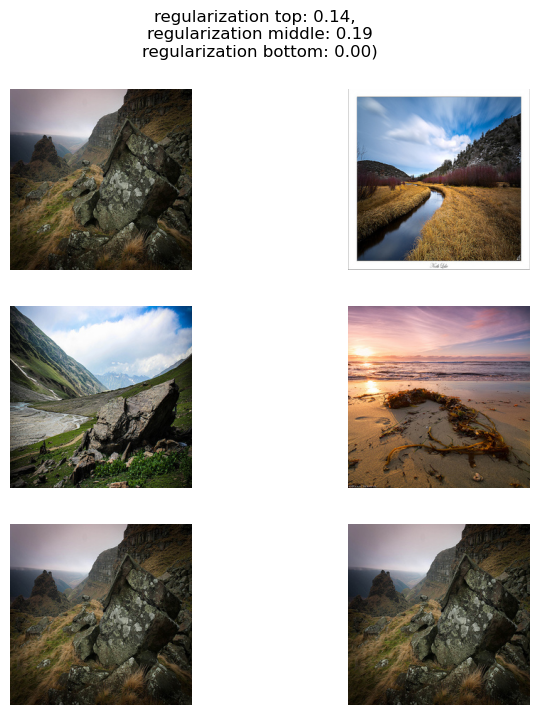

In [46]:
from matplotlib import pyplot as plt


def unnormalize(tensor):
    return tensor * 0.5 + 0.5


img_batch = next(data_iter)[0]
img_batch1, img_batch2 = img_batch[:2], img_batch[2:]

img1, img2 = unnormalize(img_batch1[0].detach().cpu()).permute(1, 2, 0), unnormalize(
    img_batch1[1].detach().cpu()).permute(1, 2, 0)
img3, img4 = unnormalize(img_batch2[0].detach().cpu()).permute(1, 2, 0), unnormalize(
    img_batch2[1].detach().cpu()).permute(1, 2, 0)

regularization1_2 = semantic_regularization(img_batch1[0].unsqueeze(0), img_batch1[1].unsqueeze(0), feature_extractor,
                                            1)
regularization3_4 = semantic_regularization(img_batch2[0].unsqueeze(0), img_batch2[1].unsqueeze(0), feature_extractor,
                                            1)
regularization1_1 = semantic_regularization(img_batch1[0].unsqueeze(0), img_batch1[0].unsqueeze(0), feature_extractor,
                                            1)

fig, axes = plt.subplots(3, 2, figsize=(8, 8), )
for ax in axes.reshape(-1):
    ax.axis("off")
axes[0, 0].imshow(img1)
axes[0, 1].imshow(img2)
axes[1, 0].imshow(img3)
axes[1, 1].imshow(img4)
axes[2, 0].imshow(img1)
axes[2, 1].imshow(img1)
fig.suptitle(f"regularization top: {regularization1_2:.2f},  \n"
             f"regularization middle: {regularization3_4:.2f}\n"
             f"regularization bottom: {regularization1_1:.2f})")
plt.show()



images with more semantically similar content have lower regularization values

In [21]:
import torch
import torch.nn as nn


# U net inspired architecture
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=1, padding=3, bias=False),
            nn.InstanceNorm2d(64),  # Normalization layer, equivalent to batch norm but for style transfer
            nn.ReLU(True),
            # Downsampling
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(128),
            nn.ReLU(True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(256),
            nn.ReLU(True),
            # Residual blocks - pretty deep network - avoid vanishing gradients
            *[ResidualBlock(256) for _ in range(9)],
            # Upsampling
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
            nn.InstanceNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
            nn.InstanceNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 3, kernel_size=7, stride=1, padding=3, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)


# CNN with linear head
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1, bias=False)
        )

    def forward(self, x):
        return self.main(x)


class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(channels),
            nn.ReLU(True),
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(channels)
        )

    def forward(self, x):
        return x + self.block(x)

# Training
$$
L(G, F, D_X, D_Y) = \mathcal{L}_{GAN}(G, D_Y, X, Y) + \mathcal{L}_{GAN}(F, D_X, Y, X) + \lambda \mathcal{L}_{cyc}(G, F) + \beta \mathcal{r}_{sem}(G, F)
$$
from https://arxiv.org/pdf/1703.10593
- update the discriminators with $\mathcal{L}_{GAN}$ (adversarial losses)
- update the generators with $\mathcal{L}_{GAN}$ and $\mathcal{L}_{cyc}$ (adversarial and cycle consistency losses)


devised by us
- $\mathcal{L}_{sem}$ is the semantic regularization - cosine similarity between features of the generated and real images

In [22]:
import pickle
from torch import optim
import os

G = Generator().to(device)
F = Generator().to(device)
Dx = Discriminator().to(device)
Dy = Discriminator().to(device)

lr = 0.0002
beta1 = 0.5
G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999))
F_optimizer = optim.Adam(F.parameters(), lr=lr, betas=(beta1, 0.999))
Dx_optimizer = optim.Adam(Dx.parameters(), lr=lr, betas=(beta1, 0.999))
Dy_optimizer = optim.Adam(Dy.parameters(), lr=lr, betas=(beta1, 0.999))

cycle_losses = []
Dx_losses = []
Dy_losses = []
G_losses = []
F_losses = []
os.makedirs("weights", exist_ok=True)


def clear_loss_history():
    cycle_losses.clear()
    Dx_losses.clear()
    Dy_losses.clear()
    G_losses.clear()
    F_losses.clear()


def train(epochs, train_loader_x, train_loader_y, G, F, Dx, Dy, G_optimizer, F_optimizer, Dx_optimizer, Dy_optimizer,
          cycle_losses, Dx_losses, Dy_losses, G_losses, F_losses, frozen_feature_extractor, beta_param, lambda_param=10,
          weight_dir="weights", log_file="cycle_gan_default.log"):
    for epoch in range(1, epochs + 1):
        for i, (real_x, real_y) in enumerate(zip(train_loader_x, train_loader_y)):
            real_x = real_x[0]
            real_y = real_y[0]  # drop labels generated by ImageFolder
            real_x = real_x.to(device)
            real_y = real_y.to(device)

            # Train Discriminators
            Dx_optimizer.zero_grad()
            Dy_optimizer.zero_grad()

            fake_y = G(real_x)
            fake_x = F(real_y)

            # adversarial losses of the discriminators min log(1 - D(x)) + log(D(G(x))) => min (1 - D(x))^2 + D(G(x))^2
            Dx_real_loss = lsgan_loss(Dx(real_x), torch.ones_like(Dx(real_x)))
            Dx_fake_loss = lsgan_loss(Dx(fake_x.detach()), torch.zeros_like(Dx(fake_x)))
            Dx_loss = (Dx_real_loss + Dx_fake_loss) * 0.5

            Dy_real_loss = lsgan_loss(Dy(real_y), torch.ones_like(Dy(real_y)))
            Dy_fake_loss = lsgan_loss(Dy(fake_y.detach()), torch.zeros_like(Dy(fake_y)))
            Dy_loss = (Dy_real_loss + Dy_fake_loss) * 0.5

            # backpropagate discriminator losses
            Dx_loss.backward()
            Dy_loss.backward()
            Dx_optimizer.step()
            Dy_optimizer.step()

            # Train Generators
            G_optimizer.zero_grad()
            F_optimizer.zero_grad()

            fake_y = G(real_x)
            fake_x = F(real_y)

            # adversarial losses of the generators max log(D(G(x))) => min (1 - D(G(x)))^2
            G_loss = lsgan_loss(Dy(fake_y), torch.ones_like(Dy(fake_y)))
            F_loss = lsgan_loss(Dx(fake_x), torch.ones_like(Dx(fake_x)))

            cycle_x = F(fake_y)
            cycle_y = G(fake_x)

            # consistency loss - l1 norm between real and reconstructed images - min l1 error
            cycle_x_loss = cycle_consistency_loss(real_x, cycle_x)
            cycle_y_loss = cycle_consistency_loss(real_y, cycle_y)
            total_cycle_loss = (cycle_x_loss + cycle_y_loss) * lambda_param + semantic_regularization(real_x, fake_y,
                                                                                                      frozen_feature_extractor,
                                                                                                      beta_param)

            # backpropagate generator losses sum adversarial and cycle loss
            total_G_loss = G_loss + total_cycle_loss
            total_F_loss = F_loss + total_cycle_loss

            total_G_loss.backward(
                retain_graph=True)  # otherwise cannot backward pass total_F_loss -> reuse total_cycle loss
            total_F_loss.backward()
            G_optimizer.step()
            F_optimizer.step()

            if i % 100 == 0:
                print(f"Epoch [{epoch}/{epochs}], Step [{i}/{len(train_loader_x)}], "
                      f"cycle loss {total_cycle_loss.item()}"
                      f"Dx Loss: {Dx_loss.item()}, Dy Loss: {Dy_loss.item()}, "
                      f"G Loss: {total_G_loss.item()}, F Loss: {total_F_loss.item()}")

                cycle_losses.append(total_cycle_loss.item())
                Dx_losses.append(Dx_loss.item())
                Dy_losses.append(Dy_loss.item())
                G_losses.append(total_G_loss.item())
                F_losses.append(total_F_loss.item())

                with open(log_file, "a+") as f:
                    f.write(f"lambda {lambda_param}; beta_param {beta_param} Epoch [{epoch}/{epochs}]\n")
        if epoch % 10 == 0:
            torch.save(G.state_dict(), f"{weight_dir}/{beta}_G_epoch_{epoch}.pth")
            torch.save(F.state_dict(), f"{weight_dir}/{beta}_F_epoch_{epoch}.pth")
    return cycle_losses, Dx_losses, Dy_losses, G_losses, F_losses


# Experiments influence of beta and lambda - cycle consistency loss 

In [23]:
import torchvision

lambdas = [0, 1, 0.5, 1, 2, 5]
betas = [10 ** (-4), 10 ** (-3), 10 ** (-2), 10 ** (-1), 1, 10]
weight_dir = "weights"
losses_dir = "losses"
os.makedirs(weight_dir, exist_ok=True)
os.makedirs(losses_dir, exist_ok=True)
lr = 0.0002
beta1 = 0.5
num_epochs = 30
feature_extractor = torchvision.models.resnet18(pretrained=True).eval().to(device)
for beta in betas:
    for l in lambdas:
        weight_dir_for_lambda = f"{weight_dir}/{l}"
        os.makedirs(weight_dir_for_lambda, exist_ok=True)
        G = Generator().to(device)
        F = Generator().to(device)
        Dx = Discriminator().to(device)
        Dy = Discriminator().to(device)

        G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999))
        F_optimizer = optim.Adam(F.parameters(), lr=lr, betas=(beta1, 0.999))
        Dx_optimizer = optim.Adam(Dx.parameters(), lr=lr, betas=(beta1, 0.999))
        Dy_optimizer = optim.Adam(Dy.parameters(), lr=lr, betas=(beta1, 0.999))

        cycle_losses, Dx_losses, Dy_losses, G_losses, F_losses = train(30, train_loader_x, train_loader_y, G, F, Dx, Dy,
                                                                       G_optimizer, F_optimizer, Dx_optimizer,
                                                                       Dy_optimizer,
                                                                       cycle_losses, Dx_losses, Dy_losses, G_losses,
                                                                       F_losses, feature_extractor, beta_param=beta,
                                                                       lambda_param=l,
                                                                       weight_dir=weight_dir_for_lambda)
        clear_loss_history()
        with open(f"{weight_dir_for_lambda}/losses_{l}.pkl", "wb") as f:
            pickle.dump({
                "cycle_losses": cycle_losses,
                "Dx_losses": Dx_losses,
                "Dy_losses": Dy_losses,
                "G_losses": G_losses,
                "F_losses": F_losses
            }, f)

/media/data/coding/mamba/envs/ssne/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU  (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return F.conv2d(input, weight, bias, self.stride,


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 